## 第九週：主題模型（英文）

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不用事先人為做標籤與註解，而是直接從文本中學習，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以英文文本為示範如何使用 LDA 模型進行主題建構與視覺化分析。<br>
<br>
這次課程分為四個部分：<br>
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. 建立LDA模型 
4. 視覺化主題模型

In [1]:
import re
from nltk.corpus import stopwords

from pprint import pprint
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc

import pyLDAvis
import pyLDAvis.gensim_models

#### 匯入資料
- 資料來源: 古騰堡-傲慢與偏見

In [2]:
#匯入資料
books = pd.read_csv('./raw_data/en_tp_clean.csv')
books = books.iloc[1:,:]
books.head()

,sentence,chapter
1,It is a truth universally acknowledged that a ...,1
2,However little known the feelings or views of ...,1
3,My dear Mr_Bennet said his lady to him one day...,1
4,Mr_Bennet replied that he had not,1
5,But it is returned she for Mrs_Long has just b...,1


## 2. LDA 主題模型

#### 資料前處理

In [3]:
# 新增stop_words
stop_words = stopwords.words('english')

In [4]:
# 將每個章節的句子合併在一起
books = books.groupby('chapter')['sentence'].apply(lambda x: " ".join(x)).reset_index()
books.head()

,chapter,sentence
0,1,It is a truth universally acknowledged that a ...
1,2,Mr_Bennet was among the earliest of those who ...
2,3,Not all that Mrs_Bennet however with the assis...
3,4,When Jane and Elizabeth were alone the former ...
4,5,Sir William Lucas had been formerly in trade i...


In [5]:
books['sentence'] = books['sentence'].str.lower()
# 去除掉停用字之後轉換成List儲存
docs = [[word for word in doc.split() if word not in stop_words] for doc in books['sentence']]
# 總共有61個chapter
len(docs)

61

#### LDA模型訓練資料轉換
1. 把常見的bigram (出現20次以上) 加入到docs裡面
    - 用 gensim 的 Phrases 模型來找出文件中常出現的 雙字詞（bigram），例如 ('mr', 'bennet') → 'mr_bennet'。
2. 建立字典（docs的詞彙表）
    - 建立token_id跟詞彙的對應
3. 將docs轉換成BOW形式
    - 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [6]:
# 計算 bigrams.
# 針對docs建立一個 bigram 模型，找出出現次數大於20次的bigram
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # 將Token (bigram) 加入到docs裡面
            docs[idx].append(token)

In [7]:
# 建立 docs 的 dictionary物件
dictionary = Dictionary(docs)
print(dictionary)

# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

Dictionary<6860 unique tokens: ['abuse', 'account', 'acknowledged', 'affect', 'agreed']...>


#### **開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [8]:
t0 = time.time()

topic_num_list = np.arange(2, 16)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # 根據不同topic_num訓練LDA模型
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5
        )
    
    loss = model.log_perplexity(corpus)
    # 計算Perplexity和PMI值
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # 將結果儲存起來
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

花費時間: 96.82636380195618 sec


#### 視覺化Perplexity 和 PMI 評估主題模型表現
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [9]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2416.134127,-0.027947
1,3,2460.494478,-0.036463
2,4,2563.683898,-0.026242
3,5,2652.413321,-0.029264
4,6,2705.724965,-0.031729
5,7,2764.846154,-0.031329
6,8,2881.676920,-0.031757
7,9,2937.824713,-0.028513
8,10,3042.276290,-0.042998
9,11,3131.659853,-0.043765


/opt/anaconda3/envs/SMA2025/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/SMA2025/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/SMA2025/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='topic_num'>

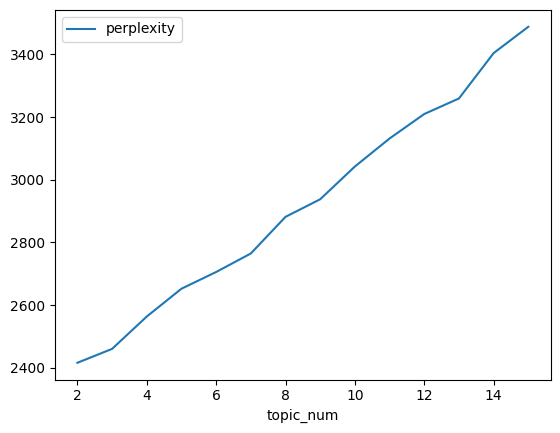

In [10]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

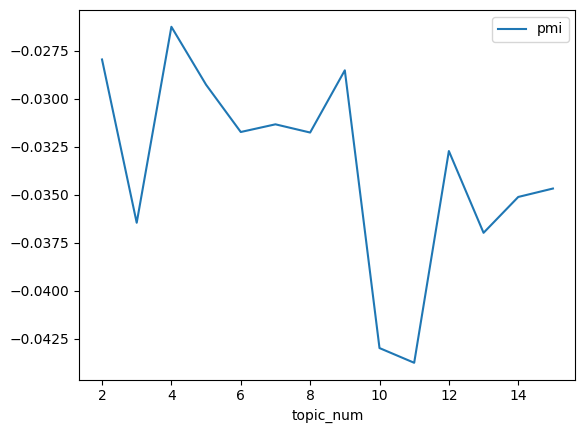

In [11]:
result.plot.line(x='topic_num', y='pmi')

## 3. LDAvis視覺化結果

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 值高且唯一，因此我們要在這兩者間取平衡
  - λ = 1.0 👉 根據 詞在該主題中出現的機率 排序（也就是根據φ值）
  - λ = 0.0 👉 根據 詞在主題中「相對其他主題」的特異性 排序
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 4 來做 LDAvis 的結果範例

In [12]:
model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes=5
    )

In [13]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.023025 -0.020126       1        1  56.406123
3      0.034320 -0.019450       2        1  32.037677
0     -0.061658 -0.014555       3        1   5.837555
1      0.004313  0.054130       4        1   5.718645, topic_info=           Term        Freq       Total Category  logprob  loglift
466       could  467.000000  467.000000  Default  30.0000  30.0000
345  mrs_bennet  244.000000  244.000000  Default  29.0000  29.0000
604    mr_darcy  401.000000  401.000000  Default  28.0000  28.0000
236       would  423.000000  423.000000  Default  27.0000  27.0000
599        miss  249.000000  249.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
74         good    7.484664  176.798422   Topic4  -6.0534  -0.3007
108      little    7.457967  174.092645   Topic4  -6.0570  -0.2889
294       every    7.577085  255.594425   Topic4  -6.0412  -0.6570
477       darcy    6.952233  130.176872   Topic4  -6.1272  -0.0684
207       think    6.987204  195.940911   Topic4  -6.1222  -0.4723

[365 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
5911      3  0.732773  abovementioned
3223      1  0.919917        accident
405       1  0.249458    accomplished
405       2  0.124729    accomplished
405       4  0.623645    accomplished
...     ...       ...             ...
236       4  0.054265           would
239       1  0.583170           young
239       2  0.325889           young
239       3  0.025728           young
239       4  0.060032           young

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

可以將LDAvis的結果儲存成html檔案

In [14]:
pyLDAvis.save_html(p, "lda_en.html")

## 4. 主題分佈的應用，搭配其他文章資訊

有了前面訓練的主題模型，接下來可以分析每一章節主題的分佈情況

In [15]:
# 取得每章的主題分佈
topics_doc = model.get_document_topics(corpus)

In [16]:
# 將gensim的表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray()
theta = pd.DataFrame(m_theta, columns=[f"topic_{i+1}" for i in range(m_theta.shape[1])])
theta

,topic_1,topic_2,topic_3,topic_4
0,0.0,0.000000,0.000000,0.997867
1,0.0,0.000000,0.997692,0.000000
2,0.0,0.999029,0.000000,0.000000
3,0.0,0.000000,0.000000,0.997607
4,0.0,0.000000,0.000000,0.998238
...,...,...,...,...
56,0.0,0.000000,0.297151,0.702148
57,0.0,0.000000,0.999240,0.000000
58,0.0,0.000000,0.342428,0.657096
59,0.0,0.000000,0.998882,0.000000


#### 將每個章節的主題機率分布視覺化

<Axes: >

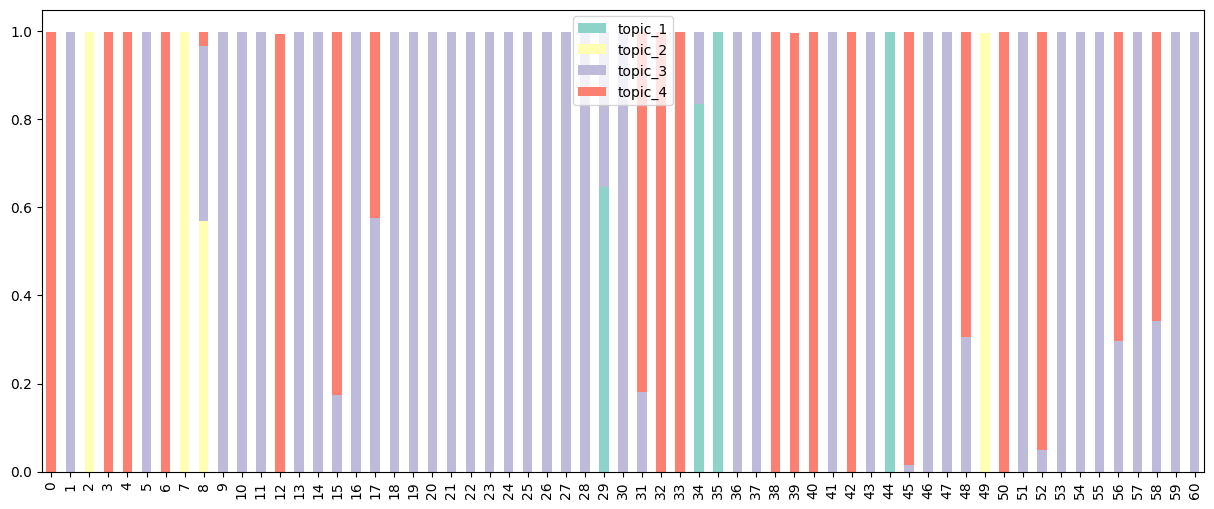

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
theta.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)